## Import Libraries

In [6]:
import numpy as np
import pandas as pd
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import seaborn as sns

## Load Dataset and Define Problem Instance

In [7]:
# Load the dataset
file_path = "D:\\IIT\\Subjects\(4601)Computational Inteligence\\CW\\Implementation\\DataSet\\instances_with_bks.csv"  
dataset = pd.read_csv(file_path)

# Select a realistic instance to work on
instance = dataset.iloc[1]  # Use a different instance for variety
num_jobs = instance["inst.jobs"]
num_machines = instance["inst.machines"]

# Simulate processing times with variability
np.random.seed(42)  # For reproducibility
processing_times = np.random.randint(10, 100, size=(num_jobs, num_machines))

# Display processing times
print("Processing Times Matrix:")
print(processing_times)

Processing Times Matrix:
[[61 24 81 70 30 92 96 84 84 97]
 [33 12 31 62 11 97 39 47 11 73]
 [69 30 42 85 67 31 98 58 68 51]
 [69 89 24 71 71 56 71 60 64 73]
 [12 60 16 30 82 48 27 13 98 69]
 [23 18 99 62 11 93 69 80 53 17]
 [56 44 87 90 45 59 13 11 15 63]
 [13 63 72 27 99 53 43 83 71 23]
 [57 24 81 87 96 71 49 94 89 91]
 [62 33 35 98 69 50 38 24 54 74]]


## Setup Genetic Algorithm

In [8]:
# Define the Genetic Algorithm structure
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimize makespan
creator.create("Individual", list, fitness=creator.FitnessMin)

# Toolbox setup
toolbox = base.Toolbox()
toolbox.register("indices", np.random.permutation, num_jobs * num_machines)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fitness function (makespan calculation)
def evaluate(individual):
    schedule = np.array(individual).reshape((num_jobs, num_machines))
    completion_times = np.zeros((num_jobs, num_machines))
    
    for job in range(num_jobs):
        for machine in range(num_machines):
            start_time = max(
                completion_times[job - 1, machine] if job > 0 else 0,
                completion_times[job, machine - 1] if machine > 0 else 0
            )
            completion_times[job, machine] = start_time + processing_times[job, machine]
    makespan = completion_times[-1, -1]
    return (makespan,)

toolbox.register("evaluate", evaluate)
# Crossover: Combines two parent solutions to create offspring
toolbox.register("mate", tools.cxTwoPoint)
# Mutation: Introduces variability by shuffling elements of an individual
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.1)  # Increased mutation rate
# Selection: Selects individuals for the next generation using tournament selection
toolbox.register("select", tools.selTournament, tournsize=5)  # Larger tournament size

c:\Users\ridmi\.conda\envs\TenserFlow\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\ridmi\.conda\envs\TenserFlow\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


## Integrate Machine Learning for Fitness Prediction

In [9]:
# Generate synthetic data for ML training with added noise
def generate_training_data(n_samples=2000):
    X, y = [], []
    for _ in range(n_samples):
        individual = toolbox.individual()
        fitness = evaluate(individual)[0]
        noisy_fitness = fitness + np.random.normal(0, 5)  # Add slight noise
        X.append(list(individual))
        y.append(noisy_fitness)
    return np.array(X), np.array(y)

# Generate data and split it
X, y = generate_training_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest regressor
ml_model = RandomForestRegressor(n_estimators=200, random_state=42)  # Increased trees for robustness
ml_model.fit(X_train, y_train)

# Evaluate ML model
y_pred = ml_model.predict(X_test)
print("ML Model Mean Absolute Error:", mean_absolute_error(y_test, y_pred))

# ML-based fitness function
def evaluate_ml(individual):
    return (ml_model.predict([individual])[0],)

toolbox.register("evaluate_ml", evaluate_ml)

ML Model Mean Absolute Error: 3.9882745535439197


## Run Genetic Algorithm with ML

In [10]:
# Run the Genetic Algorithm
def run_ga(use_ml=False):
    pop = toolbox.population(n=100)  # Increased population size
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)
    
    # Switch between actual fitness and ML predictions
    evaluate_function = toolbox.evaluate_ml if use_ml else toolbox.evaluate
    toolbox.register("evaluate", evaluate_function)
    
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.8, mutpb=0.3, ngen=150,  # Longer generations
                                       stats=stats, halloffame=hof, verbose=True)
    return hof[0], logbook

# Run GA with ML
best_solution, logbook = run_ga(use_ml=True)

# Display results
best_schedule = np.array(best_solution).reshape((num_jobs, num_machines))
best_makespan = evaluate(best_solution)[0]
print("Best Schedule (with ML):")
print(best_schedule)
print("Best Makespan (with ML):", best_makespan)

gen	nevals	min    	avg    
0  	100   	1387.44	1388.87
1  	90    	1386.88	1388.3 
2  	82    	1386.94	1387.96
3  	88    	1386.46	1387.74
4  	83    	1386.15	1387.39
5  	90    	1385.84	1387.13
6  	91    	1385.83	1386.74
7  	84    	1385.65	1386.58
8  	89    	1385.61	1386.52
9  	89    	1385.68	1386.44
10 	91    	1385.54	1386.31
11 	83    	1385.55	1386.13
12 	91    	1385.29	1386.06
13 	88    	1384.82	1385.88
14 	76    	1384.78	1385.65
15 	79    	1384.72	1385.56
16 	85    	1384.76	1385.4 
17 	91    	1384.59	1385.27
18 	84    	1384.59	1385.22
19 	89    	1384.57	1385.18
20 	84    	1384.55	1385.14
21 	90    	1384.47	1385.06
22 	89    	1384.46	1385.03
23 	87    	1384.4 	1384.93
24 	90    	1384.39	1384.95
25 	86    	1384.27	1384.99
26 	94    	1384.25	1384.87
27 	85    	1384.27	1384.79
28 	83    	1384.25	1384.88
29 	86    	1384.22	1384.86
30 	84    	1384.22	1384.86
31 	88    	1384.18	1384.78
32 	87    	1384.18	1384.59
33 	88    	1384.18	1384.74
34 	81    	1384.18	1384.57
35 	86    	1384.18	1384.62
3

## Visualization: Fitness Over Generations

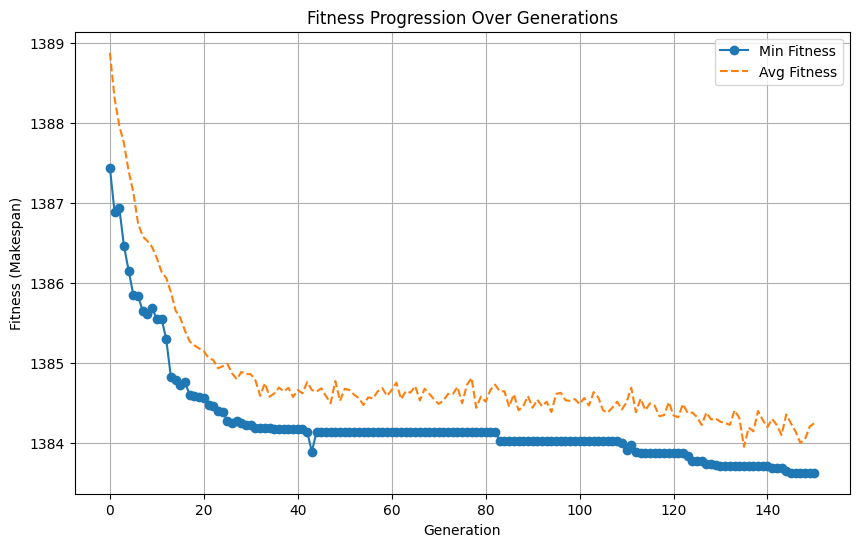

In [11]:
# Extract data from the logbook
generations = range(len(logbook))
min_fitness = [gen["min"] for gen in logbook]
avg_fitness = [gen["avg"] for gen in logbook]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(generations, min_fitness, label="Min Fitness", marker="o")
plt.plot(generations, avg_fitness, label="Avg Fitness", linestyle="--")
plt.xlabel("Generation")
plt.ylabel("Fitness (Makespan)")
plt.title("Fitness Progression Over Generations")
plt.legend()
plt.grid()
plt.show()

## Visualization: Gantt Chart of Best Schedule

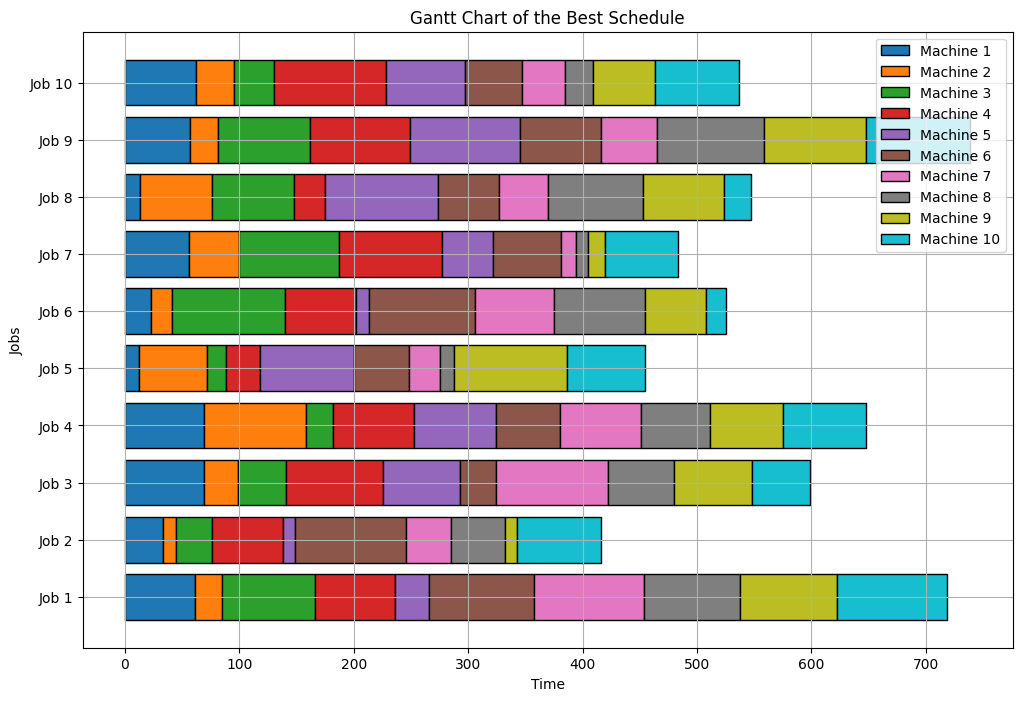

In [12]:
# Create a Gantt chart to visualize the best schedule
fig, ax = plt.subplots(figsize=(12, 8))
for job in range(num_jobs):
    start_time = 0
    for machine in range(num_machines):
        task_duration = processing_times[job, machine]
        ax.broken_barh([(start_time, task_duration)], (job - 0.4, 0.8),
                       facecolors=(f"C{machine}"), edgecolor="black", label=f"Machine {machine + 1}" if job == 0 else None)
        start_time += task_duration

# Customize chart
ax.set_xlabel("Time")
ax.set_ylabel("Jobs")
ax.set_yticks(range(num_jobs))
ax.set_yticklabels([f"Job {j+1}" for j in range(num_jobs)])
ax.set_title("Gantt Chart of the Best Schedule")
ax.grid(True)
ax.legend(loc="upper right")
plt.show()

## Visualization: ML vs Non-ML Fitness Progression

gen	nevals	min    	avg    
0  	100   	1387.62	1388.95
1  	74    	1386.96	1388.4 
2  	86    	1386.78	1388.04
3  	88    	1386.48	1387.69
4  	79    	1386.09	1387.28
5  	81    	1385.5 	1386.93
6  	88    	1385.14	1386.48
7  	85    	1385.13	1386.14
8  	86    	1385.13	1385.87
9  	88    	1384.66	1385.71
10 	89    	1384.89	1385.61
11 	93    	1384.71	1385.59
12 	87    	1384.24	1385.35
13 	87    	1384.14	1385.26
14 	84    	1383.97	1384.93
15 	85    	1383.69	1384.66
16 	78    	1383.69	1384.55
17 	86    	1383.55	1384.26
18 	84    	1383.45	1384.13
19 	91    	1383.3 	1384.23
20 	77    	1383.25	1383.96
21 	87    	1383.25	1383.97
22 	91    	1383.17	1383.82
23 	79    	1383.11	1383.89
24 	85    	1383.02	1383.67
25 	93    	1382.99	1383.78
26 	89    	1382.99	1383.58
27 	93    	1382.99	1383.47
28 	95    	1382.9 	1383.47
29 	94    	1382.86	1383.51
30 	85    	1382.86	1383.52
31 	84    	1382.86	1383.57
32 	97    	1382.85	1383.68
33 	81    	1382.85	1383.53
34 	78    	1382.85	1383.45
35 	90    	1382.85	1383.63
3

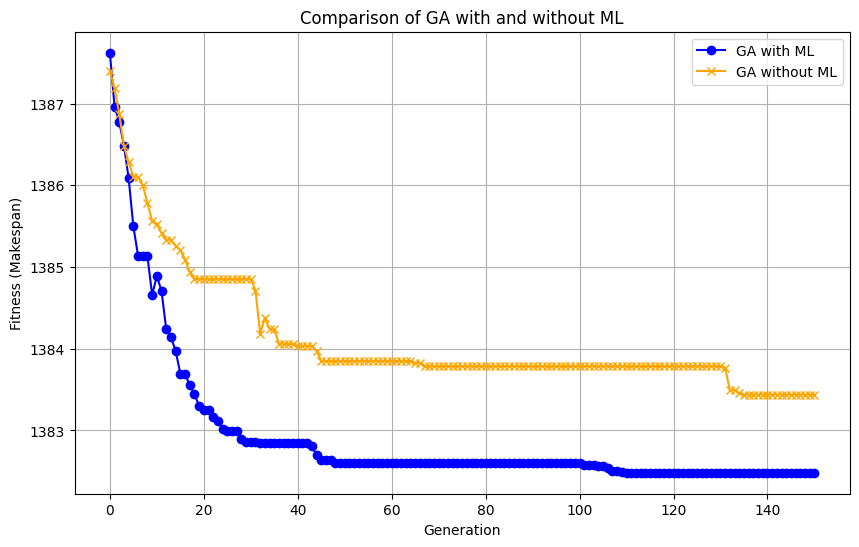

In [13]:
# Run GA with and without ML
best_solution_ml, logbook_ml = run_ga(use_ml=True)
best_solution_non_ml, logbook_non_ml = run_ga(use_ml=False)

# Compare ML and Non-ML GA fitness progression
generations = range(len(logbook_ml))  # Assuming both logbooks have the same number of generations
min_fitness_ml = [gen["min"] for gen in logbook_ml]
min_fitness_non_ml = [gen["min"] for gen in logbook_non_ml]

plt.figure(figsize=(10, 6))
plt.plot(generations, min_fitness_ml, label="GA with ML", marker="o", color="blue")
plt.plot(generations, min_fitness_non_ml, label="GA without ML", marker="x", color="orange")
plt.xlabel("Generation")
plt.ylabel("Fitness (Makespan)")
plt.title("Comparison of GA with and without ML")
plt.legend()
plt.grid()
plt.show()

## Visualization: ML Predictions vs Actual Fitness

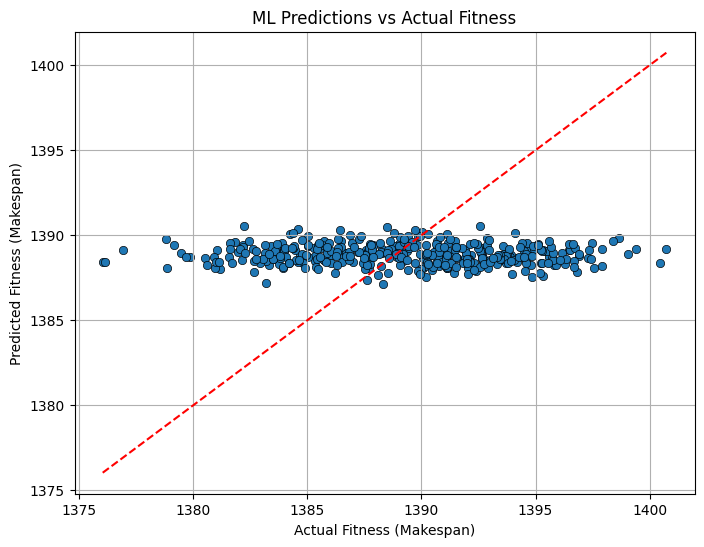

In [14]:
# Scatter plot of ML predictions vs actual fitness values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, marker="o", edgecolor="black")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")  # Diagonal line
plt.xlabel("Actual Fitness (Makespan)")
plt.ylabel("Predicted Fitness (Makespan)")
plt.title("ML Predictions vs Actual Fitness")
plt.grid()
plt.show()